# 4 - Modeling And Evaluation

 In this final step, we will train and evaluate a series of Kmeans models to find the best performing model by choosing a value for k. The steps to follow are:
 1. Load the clean, combined dataset
 2. Select audio features based on description
 3. Scale the dataset
 4. Train a range of models with different k values
 5. Evaluate and select the top 2 values for k using the Elbow method and the Siloutte score
 6. Try in a live test the selected models and select the best performing value of k

## Import Libraries

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
from scipy.spatial import distance_matrix

# Define the root path
root_path = '../'

# Change the current working directory to the root path
os.chdir(root_path)

from credentials import *
from utils import functions as f

## Load Dataset

In [2]:
# Load clean df
df = pd.read_csv("./data/6_sp_combined_dataset.csv", sep = ";")

## Select Features
The features will be selected based on the feature descriptions provided by Spotify: [Description of Audio Features](https://developer.spotify.com/documentation/web-api/reference/#/operations/get-several-audio-features)

In [3]:
# Show Columns
print(df.keys())

# Show Description
display(df.info())
display(df.describe())

Index(['track_id', 'href', 'track_link', 'track_name', 'artist', 'album_name',
       'album_release_year', 'track_duration', 'album_image', 'popularity',
       'is_hot', 'acousticness', 'danceability', 'energy', 'instrumentalness',
       'key', 'liveness', 'loudness', 'mode', 'speechiness', 'tempo',
       'time_signature', 'valence'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5691 entries, 0 to 5690
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   track_id            5691 non-null   object 
 1   href                5691 non-null   object 
 2   track_link          5691 non-null   object 
 3   track_name          5691 non-null   object 
 4   artist              5691 non-null   object 
 5   album_name          5691 non-null   object 
 6   album_release_year  5691 non-null   object 
 7   track_duration      5691 non-null   int64  
 8   album_image         5691 non-null  

None

,track_duration,popularity,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
count,5691.000000,5691.000000,5691.000000,5691.000000,5691.000000,5691.000000,5691.000000,5691.000000,5691.000000,5691.000000,5691.000000,5691.000000,5691.000000,5691.000000
mean,235.041645,14.621859,0.337579,0.544372,0.596878,0.181408,5.315059,0.217792,-9.744836,0.695836,0.092047,120.370866,3.885257,0.524128
std,103.746012,18.335749,0.343642,0.183452,0.260914,0.319172,3.542662,0.196973,5.073288,0.460093,0.124504,30.548151,0.438096,0.266621
min,7.000000,0.000000,0.000001,0.000000,0.000020,0.000000,0.000000,0.000000,-54.909000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,177.000000,1.000000,0.018200,0.416000,0.398000,0.000001,2.000000,0.095600,-12.322000,0.000000,0.034900,96.191500,4.000000,0.311000
50%,222.000000,8.000000,0.198000,0.553000,0.625000,0.000412,5.000000,0.134000,-8.718000,1.000000,0.047200,119.044000,4.000000,0.535000
75%,273.000000,22.000000,0.657000,0.683500,0.821000,0.187000,9.000000,0.283000,-6.161500,1.000000,0.086750,139.540500,4.000000,0.749000
max,1610.000000,100.000000,0.996000,0.984000,1.000000,0.993000,11.000000,0.990000,0.316000,1.000000,0.956000,245.941000,5.000000,0.991000


In [4]:
# list of selected features
selected_features = ['energy','danceability','mode', 'speechiness', 'tempo', 'acousticness', 'instrumentalness', 'valence']

# Create X df with selected features
X = df[selected_features]

## Scale Dataset

Scaling the dataset is crucial when using K-means clustering for 3 main reasons:

+ **Sensitivity to Scale**: K-means clustering relies on distance calculations, specifically Euclidean distance, so it is sensitive to feature scales, potentially leading to biased clustering due to the influence of larger-scaled features.

+ **Convergence Speed**: Scaling accelerates K-means convergence by reducing the distance centroids need to move.

+ **Improved Cluster Quality**: Scaling enhances cluster quality by basing clusters on genuine data patterns, not scale-related differences. It will also present more robustness by reducing the impact of outliers and extreme values.

In [5]:
# Select scaler
scaler = StandardScaler()

# Fit scaler
scaler.fit(X)

# Transform dataset
X_scaled = scaler.transform(X)

# Save scaler
file_name = "scaler.pkl" # Path with filename
f.save_pickle_file('./scalers/', file_name, scaler)

# Convert numpy array into pandas dataframe
X_scaled_df = pd.DataFrame(X_scaled, columns = X.columns)

# Show transformed df
display(X_scaled_df.describe())

,energy,danceability,mode,speechiness,tempo,acousticness,instrumentalness,valence
count,5.691000e+03,5.691000e+03,5.691000e+03,5.691000e+03,5.691000e+03,5.691000e+03,5.691000e+03,5.691000e+03
mean,8.989471e-17,-3.620759e-17,-7.054237e-17,9.364032e-18,3.096373e-16,2.746783e-17,-6.429969e-17,1.123684e-17
std,1.000088e+00,1.000088e+00,1.000088e+00,1.000088e+00,1.000088e+00,1.000088e+00,1.000088e+00,1.000088e+00
min,-2.287770e+00,-2.967636e+00,-1.512513e+00,-7.393700e-01,-3.940711e+00,-9.824387e-01,-5.684202e-01,-1.965985e+00
25%,-7.623051e-01,-6.998163e-01,-1.512513e+00,-4.590335e-01,-7.915861e-01,-9.294754e-01,-5.684169e-01,-7.994342e-01
50%,1.077905e-01,4.703780e-02,6.611514e-01,-3.602330e-01,-4.343906e-02,-4.062104e-01,-5.671292e-01,4.078211e-02
75%,8.590624e-01,7.584572e-01,6.611514e-01,-4.254513e-02,6.275770e-01,9.295995e-01,1.752249e-02,8.434888e-01
max,1.545173e+00,2.396630e+00,6.611514e-01,6.939760e+00,4.110925e+00,1.916178e+00,2.543029e+00,1.751222e+00


## Model Training

We will traing a series of models with k values (number of clusters) ranging from 2 to 29. The fitting is done by iterating through the steps shown below:

1. **Assignment**:
   - Calculate the distance between each data point and all centroids.
   - Assign each data point to the cluster with the nearest centroid.


2. **Update**:
   - Recalculate the centroids by taking the mean of data points in each cluster.

3. **Convergence Check**:
   - Check if centroids have significantly changed. If not, stop; otherwise, go back to step 2.


In [8]:
# Choose range of Ks to study
K = range(2, 30)

inertia = []
silhouette = []

for k in K:

    # Create KMeans model
    kmeans = KMeans(n_init='auto',
                    n_clusters=k,
                    random_state=42,
                    #verbose=1
                   )
    
    # Train model
    kmeans.fit(X_scaled_df)
    
    # Save model
    file_name = 'kmeans_{}.pkl'.format(str(k))
    f.save_pickle_file('./models/', file_name, kmeans)

    # Append inertia and silhouette
    inertia.append(kmeans.inertia_)
    silhouette.append(silhouette_score(X_scaled_df, kmeans.predict(X_scaled_df)))


## Model Evaluation

* To select the optimal number of clusters (k) in K-Means clustering, it is common practice to use a combination of two methods that study the values of inertia and siloutte generated during the training:

1. **Elbow method**
+ The elbow method involves plotting the inertia (within-cluster sum of squares) against k. The point where the inertia starts to level off, resembling an "elbow" in the graph, signifies an appropriate k value.
2. **Siloutte score**
    + The silhouette score measures the quality of clustering. A higher silhouette score indicates better separation between clusters. By computing the silhouette score for various k values and selecting the one with the highest score, you can pinpoint the k that results in well-defined clusters. These methods collectively aid in informed and data-driven k selection.

Text(0.5, 1.0, 'Silhouette Method showing the optimal k')

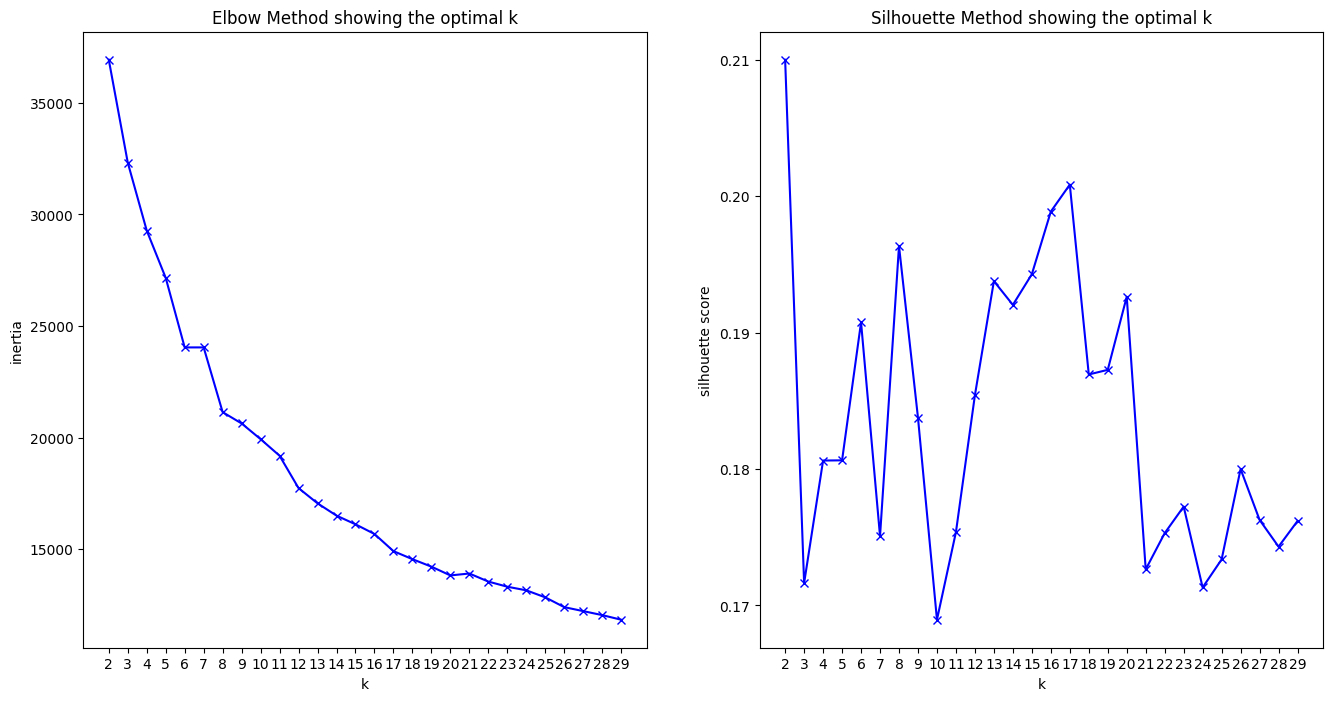

In [7]:
# Plot inertia and silhouette to select best model
fig, ax = plt.subplots(1,2,figsize=(16,8))
ax[0].plot(K, inertia, 'bx-')
ax[0].set_xlabel('k')
ax[0].set_ylabel('inertia')
ax[0].set_xticks(np.arange(min(K), max(K)+1, 1.0))
ax[0].set_title('Elbow Method showing the optimal k')
ax[1].plot(K, silhouette, 'bx-')
ax[1].set_xlabel('k')
ax[1].set_ylabel('silhouette score')
ax[1].set_xticks(np.arange(min(K), max(K)+1, 1.0))
ax[1].set_title('Silhouette Method showing the optimal k')

-> Based on the Elbow and Silhouette Score methods, we've identified two promising values for k: 8 and 17. To explore the clustering potential of our dataset, we'll implement these two k-values. 
+ Our goal is to determine the optimal choice through a process that incorporates human feedback. 

This approach allows us to make a well-informed decision about the number of clusters to use.

In [13]:
# Define the selected Ks
selected_ks = [8, 17]

# Create a copy of scaled df to add clusters
clustered_df = df.copy()

for k in selected_ks:
    model = f.read_pickle_file('./models/kmeans_{}.pkl'.format(str(k))) # Load model
    
    clusters = model.predict(X_scaled_df[selected_features]) # Predict clusters
    
    clustered_df['clusters_kmeans_{}'.format(str(k))] = clusters # Add clusters to clustered df

# Save clustered df as csv
clustered_df.to_csv('./data/7_clustered_dataset.csv',index = False, sep=";")                 

In [16]:
# Show clusters distribution for each K
for k in selected_ks:
    display(clustered_df['clusters_kmeans_{}'.format(k)].value_counts())

clusters_kmeans_8
2    1300
3     948
4     920
1     871
0     615
6     492
5     418
7     127
Name: count, dtype: int64

clusters_kmeans_17
16    713
3     469
15    466
12    423
2     413
13    392
9     386
4     367
5     341
14    325
8     290
6     262
11    225
0     215
10    204
1     116
7      84
Name: count, dtype: int64